In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac

from mdps.cattle import cMDPCattle
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [4]:
def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPCattle(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,2], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Breeding Stock(x)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [5]:
c = {"context_distribution":
        ConstantDistribution(dim=10, constant_vector=np.array([1.0, 1.4, 0.95, 0.95, 0.7, 0.3, 0.5, 1E-8, 37, 63]))
    }

In [6]:
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPCattle, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-02 13:28:48,912	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-02 13:28:48,912	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-02 13:28:51,027	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-04-02 13:29:01,612	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 17893776519228.0x the scale of `vf_clip_param`. This means that it will take more than 17893776519228.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -178937765192281.03


2022-04-02 13:29:12,041	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 10964371714299.0x the scale of `vf_clip_param`. This means that it will take more than 10964371714299.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:29:22,898	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 7474491519514.0x the scale of `vf_clip_param`. This means that it will take more than 7474491519514.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:29:33,858	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1834233883436.0x the scale of `vf_clip_param`. This means that it will take more than 1834233883436.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:29:44,811	WARNING ppo.py:245 -- The magnit

5 -5021715865011.31


2022-04-02 13:30:07,441	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 315722880146.0x the scale of `vf_clip_param`. This means that it will take more than 315722880146.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:30:19,375	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 194226399522.0x the scale of `vf_clip_param`. This means that it will take more than 194226399522.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:30:31,444	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 143045378341.0x the scale of `vf_clip_param`. This means that it will take more than 143045378341.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:30:42,849	WARNING ppo.py:245 -- The magnitude of y

10 -817759488278.7957


2022-04-02 13:31:06,371	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 56397244378.0x the scale of `vf_clip_param`. This means that it will take more than 56397244378.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:31:18,229	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 51546791299.0x the scale of `vf_clip_param`. This means that it will take more than 51546791299.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:31:29,678	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 34438345043.0x the scale of `vf_clip_param`. This means that it will take more than 34438345043.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:31:40,675	WARNING ppo.py:245 -- The magnitude of your en

15 -186844269770.1151


2022-04-02 13:32:04,134	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 11340277993.0x the scale of `vf_clip_param`. This means that it will take more than 11340277993.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:32:16,471	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 11711059739.0x the scale of `vf_clip_param`. This means that it will take more than 11711059739.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:32:28,152	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 9789966201.0x the scale of `vf_clip_param`. This means that it will take more than 9789966201.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:32:41,238	WARNING ppo.py:245 -- The magnitude of your envi

20 -43271253776.069954


2022-04-02 13:33:06,232	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3873384356.0x the scale of `vf_clip_param`. This means that it will take more than 3873384356.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:33:18,506	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3200820178.0x the scale of `vf_clip_param`. This means that it will take more than 3200820178.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:33:30,716	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2220499970.0x the scale of `vf_clip_param`. This means that it will take more than 2220499970.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:33:42,768	WARNING ppo.py:245 -- The magnitude of your environm

25 -17887787171.474552


2022-04-02 13:34:08,133	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1531806000.0x the scale of `vf_clip_param`. This means that it will take more than 1531806000.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:34:21,050	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1140298880.0x the scale of `vf_clip_param`. This means that it will take more than 1140298880.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:34:33,803	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 833886125.0x the scale of `vf_clip_param`. This means that it will take more than 833886125.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:34:46,560	WARNING ppo.py:245 -- The magnitude of your environmen

30 -4602570368.113481


2022-04-02 13:35:12,256	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 384015266.0x the scale of `vf_clip_param`. This means that it will take more than 384015266.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:35:25,209	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 374044901.0x the scale of `vf_clip_param`. This means that it will take more than 374044901.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:35:38,102	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 335339509.0x the scale of `vf_clip_param`. This means that it will take more than 335339509.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-02 13:35:51,007	WARNING ppo.py:245 -- The magnitude of your environment re

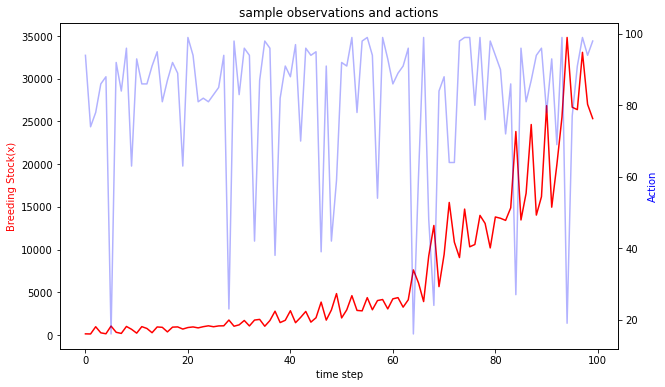

In [7]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)
plot_rollouts(gt_obs_arr, gt_act_arr)